# Programming Exercise 5: Regularized Linear Regression and Bias v.s. Variance
## Machine Learning
## Introduction

In this exercise, you will implement regularized linear regression and use it to study models with different bias-variance properties. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

To get started with the exercise, you will need to download the starter code and unzip its contents to the directory where you wish to complete the exercise. 

Files included in this exercise:

* `ex5.ipynb` - Python script that steps you through the exercise. 
* `ex5_utils.py` - All necessary functions, classes and solutions for the exercises.
* `ex4_data/ex5data1.mat` - Dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ex5_utils import *
import scipy.io as io
import scipy.optimize as opt
from IPython.display import *
from sklearn.preprocessing import OneHotEncoder 

# Setup environment variables
%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1 Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

### 1.1 Visualizing the dataset
We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset is divided into three parts:
* A <b>training</b> set that your model will learn on: `X, y`
* A <b>cross validation</b> set for determining the regularization parameter: `Xval, yval`
* A <b>test</b> set for evaluating performance. These are “unseen” examples which your model did not see during training: `Xtest, ytest`

The next step will plot the training data (<b>Figure 1</b>). In the following parts, you will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, you will implement polynomial regression to find a better fit to the data.

<b>Figure 1: Data</b>

<img src="figure1.png" align="left" height="50%" width="50%">

In [2]:
#  =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  The following code will load the dataset into your environment and plot the data.

# Load Training Data
print('\nLoading and Visualizing Data ...')

# Load from ex5data1: 
# You will have X, y, Xval, yval, Xtest, ytest in your environment
data = io.loadmat('ex5_data/ex5data1.mat')
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']
#m = Number of examples
m = X.shape[0]

print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('Xval shape: ', Xval.shape)
print('yval shape: ', yval.shape)
print('Xtest shape: ', Xtest.shape)
print('ytest shape: ', ytest.shape)


Loading and Visualizing Data ...
X shape:  (12, 1)
y shape:  (12, 1)
Xval shape:  (21, 1)
yval shape:  (21, 1)
Xtest shape:  (21, 1)
ytest shape:  (21, 1)


Plot training data


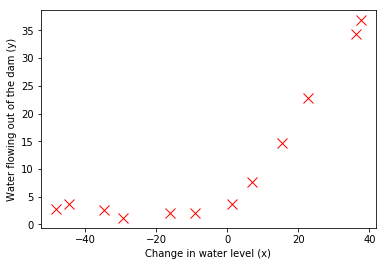

In [3]:
#m = Number of examples
m = X.shape[0]

print("Plot training data")
plt.plot(X, y, 'rx', ms=10, lw=1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

### 1.2 Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:
$$
\large{ J(\theta) = \frac{1}{2m}(\sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})^{2}}) + \frac{\lambda}{2m}(\sum^{n}_{j=1}\theta^{\theta}_{j}) ,}
$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost $J$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term. 

You should now complete the code in the file <b>linear_reg_cost_function</b>.

Your task is to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops. When you are finished, the next part of ex5.m will run your cost function using theta initialized at $[1; 1]$. You should expect to see an output of $303.993$.

In [4]:
# =========== Part 2: Regularized Linear Regression Cost =============
theta = np.ones((2, 1))
lb = 1
X_bias = np.append(np.ones((m,1)), X, axis=1)
cost_func = linearRegCostFunction(X_bias, y, lb)
J = cost_func.cost(theta)
print('Cost at theta = [1 , 1]: %f' %J)
print('(this value should be about 303.993192)')


Cost at theta = [1 , 1]: 303.993192
(this value should be about 303.993192)


### 1.3 Regularized linear regression gradient
Correspondingly, the partial derivative of regularized linear regression’s cost for $\theta_j$ is defined as

$$
\left. \large{ \begin{array}{lr}
    \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum^{m}_{i=1}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for } j = 0 \\
    \frac{\partial J(\theta)}{\partial \theta_j} = (\frac{1}{m} \sum^{m}_{i=1}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m}\theta_j & \text{for } j \geq 1
\end{array}}\right.
$$

When you are finished <b>linearRegCostFunction</b>, the next part will run your gradient function using theta initialized at $[1; 1]$.

You should expect to see a gradient of [-15.30; 598.250].

In [5]:
# =========== Part 3: Regularized Linear Regression Gradient =============

grad = cost_func.gradient(theta)
print('Gradient at theta = [1 , 1]: [{:6f} {:6f}]'.format(grad[0], grad[1]))
print('(this value should be about [-15.303016  598.250744])')

Gradient at theta = [1 , 1]: [-15.303016 598.250744]
(this value should be about [-15.303016  598.250744])


### 1.4 Fitting linear regression

Once your cost function and gradient are working correctly, the next part will run the code in <b>train_linear_reg</b> to compute the optimal values of $\theta$. This training function uses $fmincg$ to optimize the cost function. 

In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In
the later parts of the exercise, you will be using polynomial regression with regularization. 

Finally, the script should also plot the best fit line, resulting in an image similar to <b>Figure 2</b>. The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

<b>Figure 2: Linear Fit</b>

<img src="figure2.png" align="left" height="50%" width="50%">

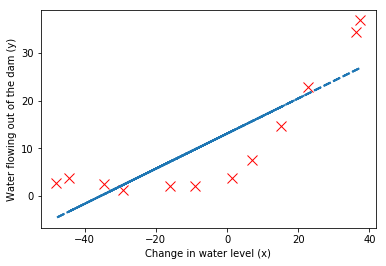

In [6]:
#  =========== Part 4: Train Linear Regression =============
#  Write Up Note: The data is non-linear, so this will not give a great fit.

# Train linear regression with lambda = 0
lb = 0
theta = train_linear_reg(X_bias, y, lb)
i = 1
# %  Plot fit over the data
plt.figure()
plt.plot(X, y, 'rx', ms=10, lw=1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, np.dot(X_bias, theta), '--', lw=2)
plt.show()

### 2 Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data. 
In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

#### 2.1 Learning curves

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in <b>learning_curve</b> so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set $X$. Specifically, for a training set size of $i$, you should use the first $i$ examples (i.e., `X[1:i, :]` and `y[1:i]`).

You can use the <b>train_linear_reg</b> function to find the $\theta$ parameters. Note that the lambda is passed as a parameter to the <b>learning_curve</b> function. After learning the \theta parameters, you should compute the <b>error</b> on the training and cross validation sets. Recall that the training error for a dataset is defined as

$$
\large{J_\text{train}(\theta) = \frac{1}{2m}[\sum^{m}_{i=1}(h_\theta(x^{(i)} - y^{(i)})^2)] . }
$$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to $0$ <i>only</i> when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., `X[1:n, :]` and `y[1:n])` (instead of the entire training set). However, for the cross validation error, you should compute it over the <i>entire</i> cross validation set. You should store the computed errors in the vectors `error_train` and `error_val`.

When you are finished, the script wil print the learning curves and produce a plot similar to <b>Figure 3</b>.

In <b>Figure 3</b>, you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a <b>high bias</b> problem in the model – the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

<b> Figure 3: Linear Regression learning curve </b>

<img src="figure3.png" align="left" height="50%" width="50%">

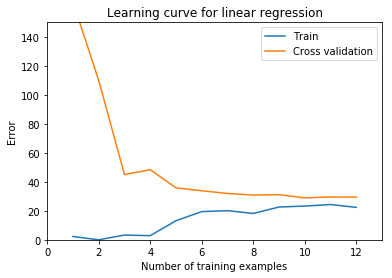

In [7]:
#  =========== Part 5: Learning Curve for Linear Regression =============
#  Write Up Note: Since the model is underfitting the data, we expect to see a graph with "high bias" -- Figure 3 

Xval_bias = np.append(np.ones(Xval.shape), Xval, axis = 1)
lb = 0
error_train, error_val = learning_curve(X_bias, y, Xval_bias, yval, lb)

plt.plot(range(1,m+1), error_train, range(1,m+1), error_val)
plt.title('Learning curve for linear regression')
#plt.legend('Train')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])
plt.legend(('Train', 'Cross validation'))
plt.show()

### 3 Polynomial regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. 
For use polynomial regression, our hypothesis has the form:

$$
h_\theta(x) = \theta_0 + \theta_1 * (\text{waterLevel}) + \theta_2 * (\text{waterLevel})^2 + ... + \theta_p * (\text{waterLevel})^p = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... +  \theta_p x_p . 
$$


Notice that by defining $x_1 = (\text{waterLevel}), x_2 = (\text{waterLevel})^2, ... , x_p = (\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the code in <b>poly_features</b> so that the function maps the original training set $X$ of size $m \times 1$ into its higher powers. Specifically, when a training set $X$ of size $m \times 1$ is passed into the function, the function should return a $m\times p$ matrix $X$ poly, where column 1 holds the original values of $X$, column 2 holds the values of $\text{X.^2}$, column 3 holds the values of $\text{X.^3}$, and so on. Note that you don't have to account for the zero-eth power in this function.

Now you have a function that will map features to a higher dimension, and the next part will apply it to the training set, the test set, and the cross validation set (which you haven't used yet).

### 3.1 Learning Polynomial Regression

After you have completed <b>poly_features</b>, the script will proceed to train polynomial regression using your linear regression cost function. Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$ ). Therefore, you will need to use feature normalization.

Before learning the parameters θ for the polynomial regression, the script will first call <b>feature_normalize</b> and normalize the features of the training set, storing the `mu`, `sigma` parameters separately. We have already implemented this function for you and it is the same function from the first exercise. After learning the parameters $\theta$, you should see two plots (<b>Figure 4,5</b>) generated for polynomial regression with $\lambda = 0$. 

From <b>Figure 4</b>, you should see that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda = 0$) model, you can see that the learning curve (<b>Figure 5</b>) shows the same effect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

<img src="figure4.png" height="40%" width="40%">

In [8]:
# =========== Part 6: Feature Mapping for Polynomial Regression =============
# One solution to this is to use polynomial regression. Y

p = 8

# Map X onto Polynomial Features and Normalize
X_poly = poly_features(X, p)

X_poly, mu, sigma = feature_normalize(X_poly) # Normalize
X_poly = np.append(np.ones((m,1)), X_poly, axis=1) #Add ones

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = poly_features(Xtest,p)
X_poly_test = X_poly_test - mu
X_poly_test = X_poly_test / sigma
X_poly_test = np.append(np.ones((X_poly_test.shape[0], 1)),
                        X_poly_test, axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = poly_features(Xval, p)
X_poly_val = X_poly_val - mu
X_poly_val = X_poly_val / sigma
X_poly_val = np.append(np.ones((X_poly_val.shape[0],1)),
                      X_poly_val, axis=1)

print('Normalized Training Example 1:\n')
print(X_poly[0,:])

Normalized Training Example 1:

[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


### 3.2 Optional (ungraded) exercise: Adjusting the regularization parameter

In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the the `lambda` parameter try $\lambda = 1, 100$. For each of these values, the script should generate a polynomial fit to the data and also a learning curve.

For $\lambda = 1$, you should see a polynomial fit that follows the data trend well (<b>Figure 6</b>) and a learning curve (<b>Figure 7</b>) showing that both the cross validation and training error converge to a relatively low value. This shows
the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off betweenbias and variance.

For $\lambda = 100$, you should see a polynomial fit (<b>Figure 8</b>) that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

<img src="figure6.png" height="40%" width="40%">
<img src="figure7.png" height="40%" width="40%">
<img src="figure8.png" height="40%" width="40%">

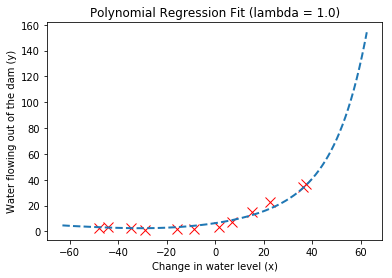

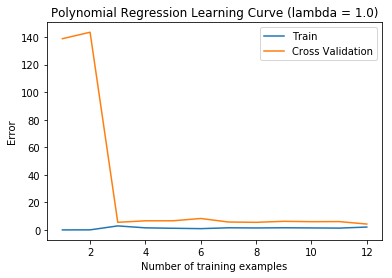

In [9]:
#  =========== Part 7: Learning Curve for Polynomial Regression =============
#  Now, you will get to experiment with polynomial regression with multiple
#  values of lambda. 
lb = 1
theta = train_linear_reg(X_poly, y, lb)

plt.figure(1)
plt.plot(X, y, 'rx', ms=10, lw=1.5)
plotFit(np.min(X), np.max(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %.1f)' %lb)

plt.figure(2)
error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, lb)
plt.plot(range(1,m+1), error_train, range(1,m+1), error_val)
plt.title('Polynomial Regression Learning Curve (lambda = %.1f)' %lb)
plt.xlabel('Number of training examples')
plt.ylabel('Error')

plt.legend(('Train', 'Cross Validation'))
plt.show()

### 3.3 Selecting λ using a cross validation set

From the previous parts of the exercise, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda=1$) can provide a good fit
to the data.

In this section, you will implement an automated method to select the $\lambda$ parameter. Concretely, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

Your task is to complete the code in <b>validation_curve</b>. Specifically, you should should use the <b>train_linear_reg</b> function to train the model using different values of $\lambda$ and compute the training error and cross validation error.

You should try $\lambda$ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}.
After you have completed the code, the next part  will run your function can plot a cross validation curve of error v.s. $\lambda$ that allows you select which $\lambda$ parameter to use. You should see a plot similar to <b>Figure 9</b>. In this
figure, we can see that the best value of $\lambda$ is around $3$. Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

<img src="figure9.png" height="40%" width="50%">

In [ ]:
np.ze

In [10]:
#  =========== Part 8: Validation for Selecting Lambda =============
#  You will now implement validationCurve to test various values of 
#  lambda on a validation set. You will then use this to select the
#  "best" lambda value.

lambda_vec, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)
plt.plot(lambda_vec, error_train, lambda_vec, error_val)
plt.legend(('Train', 'Cross Validation'))
plt.xlabel('lambda')
plt.ylabel('Error')
plt.axis([0, 10, 0, 20])
plt.show()
print('lambda\t\tTrain Error\t Validation Error')
for i in range(len(lambda_vec)):
    print('%f\t  %f\t   %f' %tuple((lambda_vec[i], error_train[i], error_val[i])))
    


NameError: name 'error_train' is not defined